In [12]:
!pip install arviz
!pip install pymc3==3.8

In [13]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix

In [14]:
df=pd.read_csv('/preprocessed.csv',sep = ',')
df=df.fillna(0)
#def format_data(df):
#    print(df.info())
#    # Targets are final grade of student
#    labels = df['units_sold']
#    normalized_df=( labels-labels.mean())/ labels.std()
#    return normalized_df
#df=format_data(df)

In [15]:
df.head()

,Unnamed: 0,price,retail_price,units_sold,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture,tag_quality,tag_count,title_localised,com_same_name,subtitle_rating,discount_rate,merch_pop_proc,color__Blue,color__Pink,color__RED,color__Rose red,color__applegreen,color__apricot,color__army,color__army green,color__beige,...,color__pink,color__pink & black,color__pink & blue,color__pink & grey,color__pink & white,color__prussianblue,color__purple,color__rainbow,color__red,color__red & blue,color__red & yellow,color__redgold,color__silver,color__star,color__tan,color__violet,color__watermelonred,color__white,color__white & black,color__white & red,color__whiteother,color__whitestripe,color__wine,color__wine red,color__yellow,size__M,size__OTHER,size__S,size__XL,size__XS,size__XXL,size__XXS,size__XXXS,size__XXXXL,size__XXXXXL,country__CN,country__GB,country__SG,country__US,country__VE
0,0,16.00,14,100,0,3.76,0.481481,0.148148,0.185185,0.018519,0.166667,0,0,0,0,50,4,0,34,50,1.0,568,4.128521,0,0.7,24,0,1,0,-0.142857,0.095070,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,8.00,22,20000,1,3.45,0.369845,0.167400,0.182233,0.104971,0.175550,0,0,0,0,50,2,0,41,50,1.0,17752,3.899673,0,0.5,15,1,1,1,0.636364,0.345595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,8.00,43,100,0,3.57,0.357143,0.285714,0.142857,0.000000,0.214286,0,0,0,0,1,3,0,36,50,1.0,295,3.989831,0,0.3,19,1,1,1,0.813953,0.047458,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,3,8.00,8,5000,1,4.03,0.509499,0.205527,0.150259,0.072539,0.062176,0,0,0,0,50,2,0,41,50,0.0,23832,4.020435,0,0.6,18,1,1,0,0.000000,0.024295,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,4,2.72,3,100,1,3.10,0.300000,0.200000,0.100000,0.100000,0.300000,0,0,0,0,1,1,0,35,50,1.0,14482,4.001588,0,0.6,13,1,0,1,0.093333,0.001381,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
labels = df['units_sold']
normalized_df=( labels-labels.mean())/ labels.std()

normalized_df.head()

0   -0.453059
1    1.673801
2   -0.453059
3    0.070640
4   -0.453059
Name: units_sold, dtype: float64

In [17]:

#The first model with priors having uniform distributions
lower=-10**6
higher=10**6
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=0, upper= 20)
    beta_rating=pm.Uniform('beta_rating',0, 5)
    beta_merch_pop_proc=pm.Uniform('beta_merch_pop_proc', df['merch_pop_proc'].min(), df['merch_pop_proc'].max())
    beta_price=pm.Uniform('beta_price',df['price'].min(), df['price'].max())
    beta_retail_price=pm.Uniform('beta_retail_price', df['retail_price'].min(), df['retail_price'].max())
    #beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p',beta_0+pm.math.dot(beta_rating,df['rating'])+
                               pm.math.dot(beta_merch_pop_proc,df['merch_pop_proc'])+
                               pm.math.dot(beta_price,df['price'])+
                               pm.math.dot(beta_retail_price,df['retail_price']))
                              #  pm.math.dot(beta_retail_price,df['retail_price']))
with first_model:
    #fit the data 
    observed=pm.Categorical("y", p, observed=normalized_df)
    # start=pm.find_MAP()
    # step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(draws=2000, tune = 1000)
    # burned_trace=trace[15000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_retail_price, beta_price, beta_merch_pop_proc, beta_rating, beta_0]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:08<00:00, 340.75it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


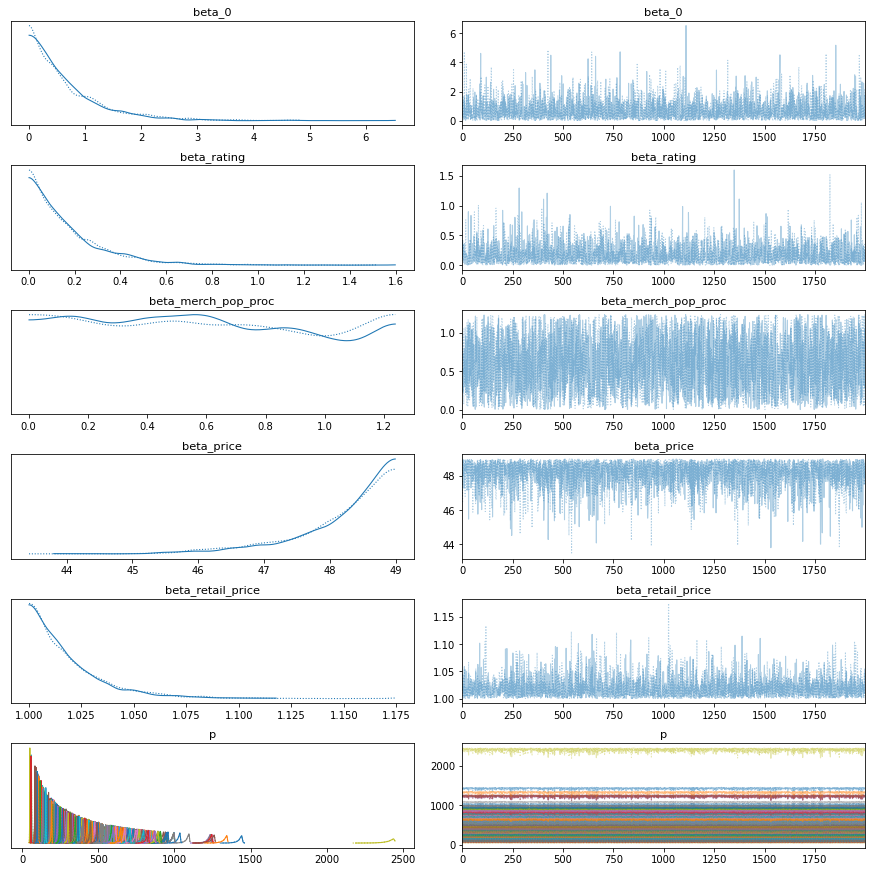

In [18]:
pm.traceplot(trace)
plt.show()

In [19]:
#the mean of these posterior distributions.

coeffs=['beta_0', 'beta_rating', 'beta_merch_pop_proc', 'beta_price', 'beta_retail_price']
d=dict()
for item in coeffs:
    d[item]=[trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

,beta_0,beta_rating,beta_merch_pop_proc,beta_price,beta_retail_price
0,0.681255,0.172336,0.600398,48.171327,1.01898


In [20]:
pm.stats.hpd(trace['beta_0'])
coeffs=['beta_0', 'beta_rating', 'beta_merch_pop_proc', 'beta_price', 'beta_retail_price']
interval=dict()
for item in coeffs:
    interval[item]=pm.stats.hpd(trace[item]) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


,beta_0,beta_rating,beta_merch_pop_proc,beta_price,beta_retail_price
lower,0.000204,0.000120,0.069045,46.629939,1.000000
upper,1.931425,0.471788,1.238035,48.999836,1.053139


In [21]:
from sklearn.linear_model import LogisticRegression
X=df.iloc[:, 1: -1]
y=df['units_sold']
logit=LogisticRegression()
logit_model=logit.fit(X,y)
pd.DataFrame(logit_model.coef_, columns=X.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,price,retail_price,units_sold,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture,tag_quality,tag_count,title_localised,com_same_name,subtitle_rating,discount_rate,merch_pop_proc,color__Blue,color__Pink,color__RED,color__Rose red,color__applegreen,color__apricot,color__army,color__army green,color__beige,color__black,...,color__otherprint,color__pink,color__pink & black,color__pink & blue,color__pink & grey,color__pink & white,color__prussianblue,color__purple,color__rainbow,color__red,color__red & blue,color__red & yellow,color__redgold,color__silver,color__star,color__tan,color__violet,color__watermelonred,color__white,color__white & black,color__white & red,color__whiteother,color__whitestripe,color__wine,color__wine red,color__yellow,size__M,size__OTHER,size__S,size__XL,size__XS,size__XXL,size__XXS,size__XXXS,size__XXXXL,size__XXXXXL,country__CN,country__GB,country__SG,country__US
0,-0.000005,-6.787184e-07,-0.001736,-6.845893e-07,-0.000002,-6.602094e-07,-2.336743e-07,-2.345816e-07,-4.708544e-08,-1.934267e-07,-2.055857e-07,-4.239432e-08,-1.245397e-07,-3.865173e-08,-0.000027,-1.279659e-06,-5.784523e-09,-0.000027,-0.000033,-2.796689e-07,0.000002,-0.000003,-9.940507e-08,-4.945116e-07,-0.000014,-6.729264e-07,-6.361116e-07,-4.345918e-07,9.655556e-09,-1.853049e-07,-7.118505e-11,-1.070718e-09,-1.557992e-09,-1.488630e-09,-5.450452e-09,-4.421166e-09,-1.803860e-09,-1.032441e-10,-2.578817e-08,-7.871912e-08,...,-2.716152e-09,-3.770914e-08,-5.364729e-09,-3.476265e-09,-2.044842e-09,-5.458238e-09,-1.908799e-09,1.091851e-08,-2.752004e-09,-2.036529e-07,-1.701240e-09,-1.586708e-09,-1.460535e-11,-3.239592e-09,-2.483686e-10,-2.730168e-09,-2.027001e-09,-4.889828e-10,1.233194e-07,-2.030052e-09,-4.868263e-10,-2.745708e-09,-2.306691e-10,-4.451182e-09,-1.117643e-11,-1.311417e-07,-1.105904e-07,2.298877e-08,-2.536415e-07,-2.152766e-08,-2.034535e-07,-2.373448e-09,-4.881486e-08,-1.145842e-08,2.274490e-08,-1.587260e-09,-5.955764e-07,-1.988291e-09,-2.734109e-09,-3.816200e-08
1,-0.000004,-1.516879e-05,-0.001672,-3.339539e-07,-0.000001,-6.955281e-08,-1.013603e-07,-1.455895e-07,7.433497e-08,-9.722438e-08,-2.065946e-07,-4.260750e-08,-1.252151e-07,-3.877208e-08,-0.000026,-8.460160e-07,-5.815625e-09,-0.000015,-0.000019,2.159431e-08,0.000002,-0.000001,-2.021056e-07,-2.488962e-07,-0.000007,-5.295143e-07,-1.881196e-07,-3.640574e-08,-5.446376e-08,-9.670688e-08,-7.282528e-11,-1.089421e-09,-1.572978e-09,-1.498166e-09,-5.454957e-09,-4.438288e-09,-1.817361e-09,-1.051761e-10,-2.587217e-08,-2.324091e-07,...,-2.718373e-09,-1.309221e-08,1.997097e-08,-3.495936e-09,-2.060738e-09,-5.463315e-09,-1.921168e-09,1.059158e-08,2.258736e-08,-1.538586e-07,-1.715419e-09,-1.601680e-09,-1.465531e-11,-3.259523e-09,-2.553183e-10,-2.732732e-09,-2.038024e-09,-5.028180e-10,-3.023518e-08,-2.044697e-09,-4.945617e-10,-2.748028e-09,-2.330410e-10,-4.468239e-09,-1.117960e-11,2.021736e-08,-2.130938e-07,-2.059980e-07,-1.310881e-07,-2.160651e-08,2.252597e-07,-2.782451e-08,7.728011e-08,-1.150448e-08,-2.619238e-09,-1.598696e-09,-4.021381e-07,-1.999816e-09,-2.739547e-09,1.234319e-08
2,0.000073,2.040902e-04,-0.002581,4.476459e-06,0.000034,4.014884e-06,1.666546e-06,1.320135e-06,6.105145e-07,1.460911e-06,8.708869e-07,1.754964e-07,4.163552e-07,2.790353e-07,0.000256,2.026281e-05,4.010923e-08,0.000364,0.000453,2.766500e-06,0.000038,0.000036,7.448812e-07,4.896071e-06,0.000154,7.511386e-06,8.253113e-06,7.207303e-06,2.507165e-06,7.088544e-07,-4.475233e-10,-4.579552e-09,-2.260505e-09,2.029000e-08,4.531609e-08,2.048084e-08,-1.930180e-09,-4.094076e-10,1.473085e-07,1.739084e-06,...,2.264697e-08,6.020708e-07,1.971772e-08,4.182129e-08,-2.262867e-09,4.530969e-08,-1.804074e-09,2.200075e-07,-2.77760

In [23]:
logit_prediction=logit_model.predict(X)

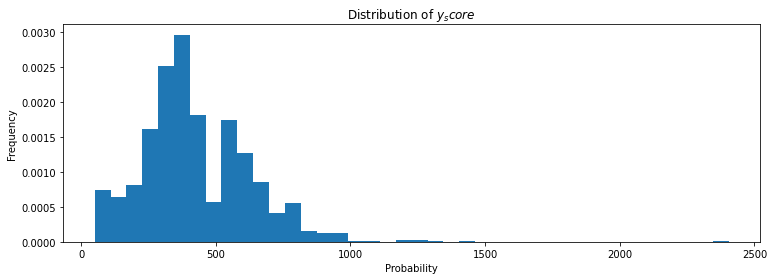

In [24]:
#compute the average probability of predicting 1. 
y_score = np.mean(trace['p'], axis=0)
#histogram of the distribution
figsize(12.5,4)
plt.hist(y_score, bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $y_score$')
plt.show()

In [25]:
first_model_prediction=[1 if x >0.5 else 0 for x in y_score]

In [26]:
first_model_confussion_matrix =confusion_matrix(df['units_sold'], first_model_prediction)
first_model_confussion_matrix


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 63,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 76,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [509,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [405,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [217,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [177,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [103,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 17,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [27]:
import sklearn
from sklearn.metrics import classification_report
print(sklearn.metrics.classification_report(y, first_model_prediction))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00      63.0
          50       0.00      0.00      0.00      76.0
         100       0.00      0.00      0.00     509.0
        1000       0.00      0.00      0.00     405.0
        5000       0.00      0.00      0.00     217.0
       10000       0.00      0.00      0.00     177.0
       20000       0.00      0.00      0.00     103.0
       50000       0.00      0.00      0.00      17.0
      100000       0.00      0.00      0.00       6.0

    accuracy                           0.00    1573.0
   macro avg       0.00      0.00      0.00    1573.0
weighted avg       0.00      0.00      0.00    1573.0



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
pred_scores = dict(y_true=df['units_sold'],y_score=y_score)
print(sklearn.metrics.classification_report(y, logit_prediction))

              precision    recall  f1-score   support

          10       0.00      0.00      0.00        63
          50       0.00      0.00      0.00        76
         100       0.72      0.26      0.38       509
        1000       0.20      0.29      0.23       405
        5000       0.00      0.00      0.00       217
       10000       0.14      0.32      0.20       177
       20000       0.21      0.79      0.34       103
       50000       0.00      0.00      0.00        17
      100000       0.00      0.00      0.00         6

    accuracy                           0.25      1573
   macro avg       0.14      0.18      0.13      1573
weighted avg       0.31      0.25      0.23      1573



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
logit_prediction

array([ 1000, 20000,  1000, ...,  1000,  1000,  1000])